# Linear Notebook

### Implements the training, testing and evaluation scripts for the Linear architecture in a segemented and organised manner.

## 1. Importing Relevant Modules


In [1]:
import numpy as np
import torch
import torch.optim 
from torch.utils.data import DataLoader, TensorDataset
import glob

import os
from tqdm import tqdm
import random
import time
import torch
import pandas as pd
import matplotlib.pyplot as plt
import psutil
import json
from matplotlib.ticker import AutoMinorLocator

import data_utils as du
import linear_tools as nt
import model_eval as me

import importlib

importlib.reload(me)
importlib.reload(nt)
importlib.reload(du)

DEVICE = torch.device("mps")

s = 42

torch.use_deterministic_algorithms(True)
torch.backends.mps.deterministic = True
torch.backends.mps.benchmark = False

np.random.seed(s)
torch.manual_seed(s)
torch.mps.manual_seed(s)
random.seed(s)

os.chdir('/Users/Mak/Desktop/Imperial College London/Year Four/MSci Project/Codebase/')



## 2. Setting Variables

* `normal_path`: The Directory to stores min-max normalised data and model outputs.

* `raw_path`: The directory storing csvs and json files from the MC Simulation Software.

    * CSV: Event-wise observables data - in the order: q2, cos_theta_l, cos_theta_d, phi

    * JSON: The input wilson coefficients for the simulation software.

* `number_bins`: The number of bins in each dimension of the simulation data

* `train_amt`: How many of the MC dataset to used to train the model. This is usually ~70-80% of the dataset.

In [8]:
normal_path = 'nn_outputs/wilson_mu_csr_cvr'

raw_path = 'raw_data/dstore_mu_csr_cvr'

number_bins = 10

## 3. Normalising Variables

* Use set variables min-max normalise observables and construct 4d histograms. Then min-max normalise the bin-heights as well.

* Only needs to be run once per dataset.

In [8]:
du.file_to_normalise_4d(raw_path, normal_path, number_bins, bkg=False) 

Processing File No. model_WET_tau_633: 100%|██████████| 3556/3556 [10:02<00:00,  5.91it/s] 


## 4. Load in Data:

1. Min-max normalise the bin-heights of the whole dataset

2. Load in min-max normalised data, store them in appropriate variables and create dataloaders for model pass through.


In [9]:
number_of_files = len(glob.glob(raw_path + '/*.csv'))

train_amount = int(0.7 * number_of_files)
val_amount = int(0.15 * number_of_files)

In [10]:
train_inputs, train_targets, val_test_inputs, val_test_targets, file_names = du.load_minmax_heights(normal_path, train_amount)

# =-=-=-= Splitting the remaining data into validation and testing datasets =-=-=-=
val_inputs, val_targets = val_test_inputs[:val_amount], val_test_targets[:val_amount]

test_inputs, test_targets = val_test_inputs[val_amount:], val_test_targets[val_amount:]

# =-=-=-= Load in the Bayesian Optimised Hyperparmaeters into a Dictionary =-=-=-=
# Fix This to be compatible with Linear model
# cfg =  nt.BO_CVAE(normal_path, train_inputs, train_targets)

cfg = {'batch_train' : 64,
       'batch_test' : 8,
       'epochs' : 35,
       'dim': (len(train_inputs[0]), number_bins**4),
       'lr' : 1e-3,
       'loss_func' : torch.nn.HuberLoss(delta=0.02)}

CSV Files: Bin Heights Already Normalised.


## 4(a). Create Data-Loaders with the above data, Ready for Model Passthrough

In [11]:
# =-=-= DataLoader Initialisation =-=-=
load_train = DataLoader(TensorDataset(train_inputs, train_targets), batch_size=cfg['batch_train'], shuffle=True, num_workers=0)

load_val = DataLoader(TensorDataset(val_inputs, val_targets), batch_size=cfg['batch_test'], shuffle=False, num_workers=0)

load_test = DataLoader(TensorDataset(test_inputs, test_targets), batch_size=cfg['batch_test'], shuffle=False, num_workers=0)

# =-=-= DataLoader Used for Model Output Storage Only =-=-=
load_vis = DataLoader(TensorDataset(test_inputs, test_targets), batch_size=1, shuffle=False, num_workers=0)

## 5. Training the Model:

1. Initialise loss function, Optimised-Model, and Optimiser.

2. Initialise variables to store loss evolution and Early Stopping parameters.
    - Loss evolution plotted later as a sanity check.

    - Early Stopping: adjust only `early_stopping_patience` (integer) to adjust how strict training should be.

3. Run the training loop - `train_epoch_early` in the `linear_tools.py` notebook takes in:
    - Model, Training dataloader, Validation dataloader, Loss Function, Optimiser, and operating DEVICE (GPU or CPU)

    - This function takes care of all the loss calculation, backpropagation and optimiser steps.

    - Returns Losses, which are stored and compared for early stopping.

4. Store the Trained Model - Adjust the filename however you want - Variable: `save_path`

In [ ]:
# =-=-=-= 1. Define the Loss Function and Model using Bayesian Optimised Hyperparameters =-=-=-=
loss_func = cfg['loss_func']
base = nt.base_model(*cfg['dim'])
base.to(DEVICE)

# =-=-=-= 1. Optimiser specified =-=-=-=
optimiser = torch.optim.AdamW(base.parameters(), lr=1e-3, weight_decay=1e-4)

# 2. Variables to store losses plotted out later
loss_evol = []
val_loss_evol = []

# 2. Early Stopping Conditions - adjust only the patience value based on How constrained you want it.
early_stopping_patience = 25
best_val_loss = np.inf
epochs_without_improvement = 0

# 3. Training loops
for epoch in (pbar := tqdm(range(cfg['epochs']))):
    avg_loss, avg_val_loss = nt.train_epoch_early(base, load_train, load_val, loss_func, optimiser, DEVICE)
    pbar.set_description(f"Training Epoch: {epoch + 1}/{cfg['epochs']}, Avg. Training Loss: {avg_loss:.5f}, Avg. Validation Loss: {avg_val_loss:.5f}")

    loss_evol.append(avg_loss)
    val_loss_evol.append(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0

    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# =-=-=-= 4. Change normal path where appropriate =-=-=-=-=
save_path = normal_path + '/linear_mu_4d.pth'
torch.save(base.state_dict(), save_path)

# plt.plot(list(range(cfg['epochs'])), loss_evol)

Training Epoch: 35/35, Avg. Training Loss: 0.00039, Avg. Validation Loss: 0.00036: 100%|██████████| 35/35 [00:53<00:00,  1.54s/it]


## 5(a). Training-Validation Loss Evolution Plot

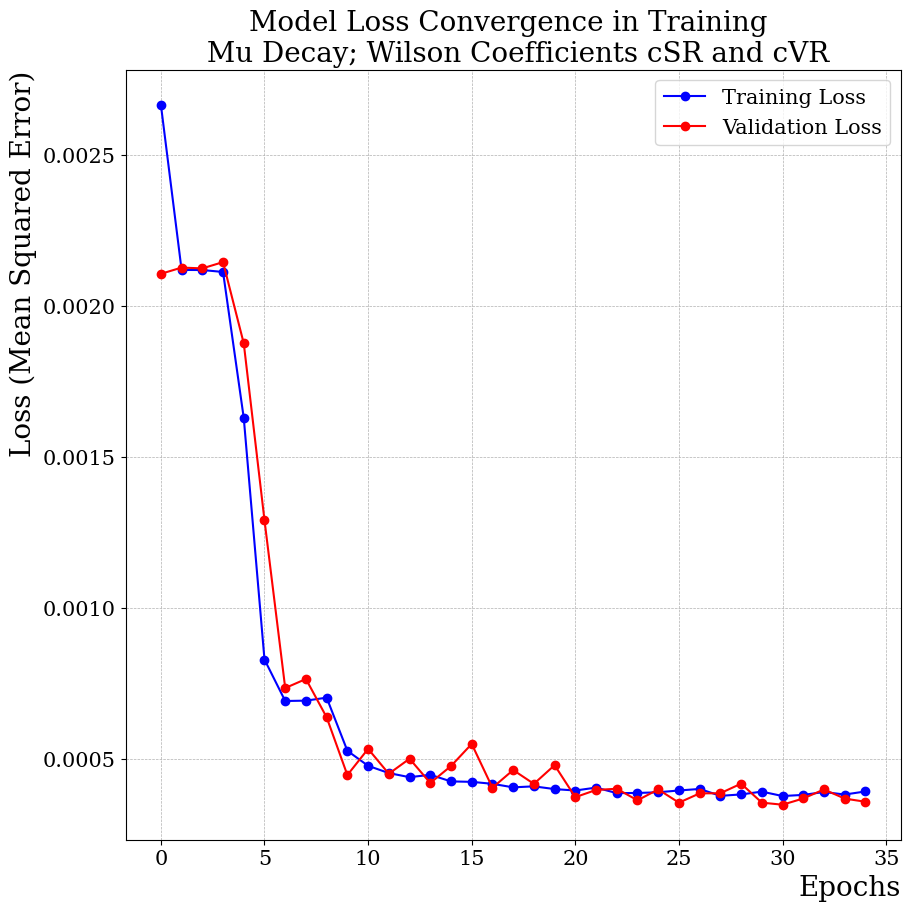

In [13]:
plt.figure(figsize=(10, 10))
plt.rcParams["font.family"] = "Serif"
plt.rcParams['font.size'] = 15
plt.plot(list(range(cfg['epochs']))[:len(loss_evol)], loss_evol, 'o-', color='blue', label='Training Loss')
plt.plot(list(range(cfg['epochs']))[:len(loss_evol)], val_loss_evol, 'o-', color='red', label='Validation Loss')

plt.xlabel('Epochs', fontsize=20, loc='right')
plt.ylabel('Loss (Mean Squared Error)', fontsize=20, loc='top')
plt.title('Model Loss Convergence in Training \n Mu Decay; Wilson Coefficients cSR and cVR', fontsize=20)
# plt.yscale('log')

plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.grid(which='minor', linestyle=':', linewidth=0.5)

plt.legend()

## 6. Testing the Model

1. Initialising loss function, retrieving the trained model and loading it in.

2. Run the testing function - evaluates the whole testing set and returns losses
    - Good performance here should give values similar to the training loss

3. Goes 1 by 1 - Using visualisation dataset to extract model outputs for each dataset 
    - Visualise Each dataset compared to EOS and directly verify performance..

In [14]:
# =-=-= 1. Initialising of Testing Variables =-=-=
best_model = nt.base_model(*cfg['dim'])

# =-=-= 1. Load best model data =-=-=
save_path = normal_path + '/linear_mu_4d.pth'
loss_func = cfg['loss_func']
best_model.load_state_dict(torch.load(save_path, weights_only = False))
best_model.to(DEVICE)

# =-=-= 2. Run the testing epoch - Operates like the training epoch without gradient calculation =-=-=
out = nt.test_epoch(best_model, load_test, loss_func, DEVICE)
print('Average Loss of Test Set', out)

# =-=-= 3. Store the model's outputs for the testing dataset =-=-=
store_test = nt.test_visualise_4d(best_model, load_vis, DEVICE, train_amount + val_amount, normal_path, number_bins, file_names)

Average Loss of Test Set 0.00035737032320962023


## 6(a). Plot out Integrated Histogram of One Variable

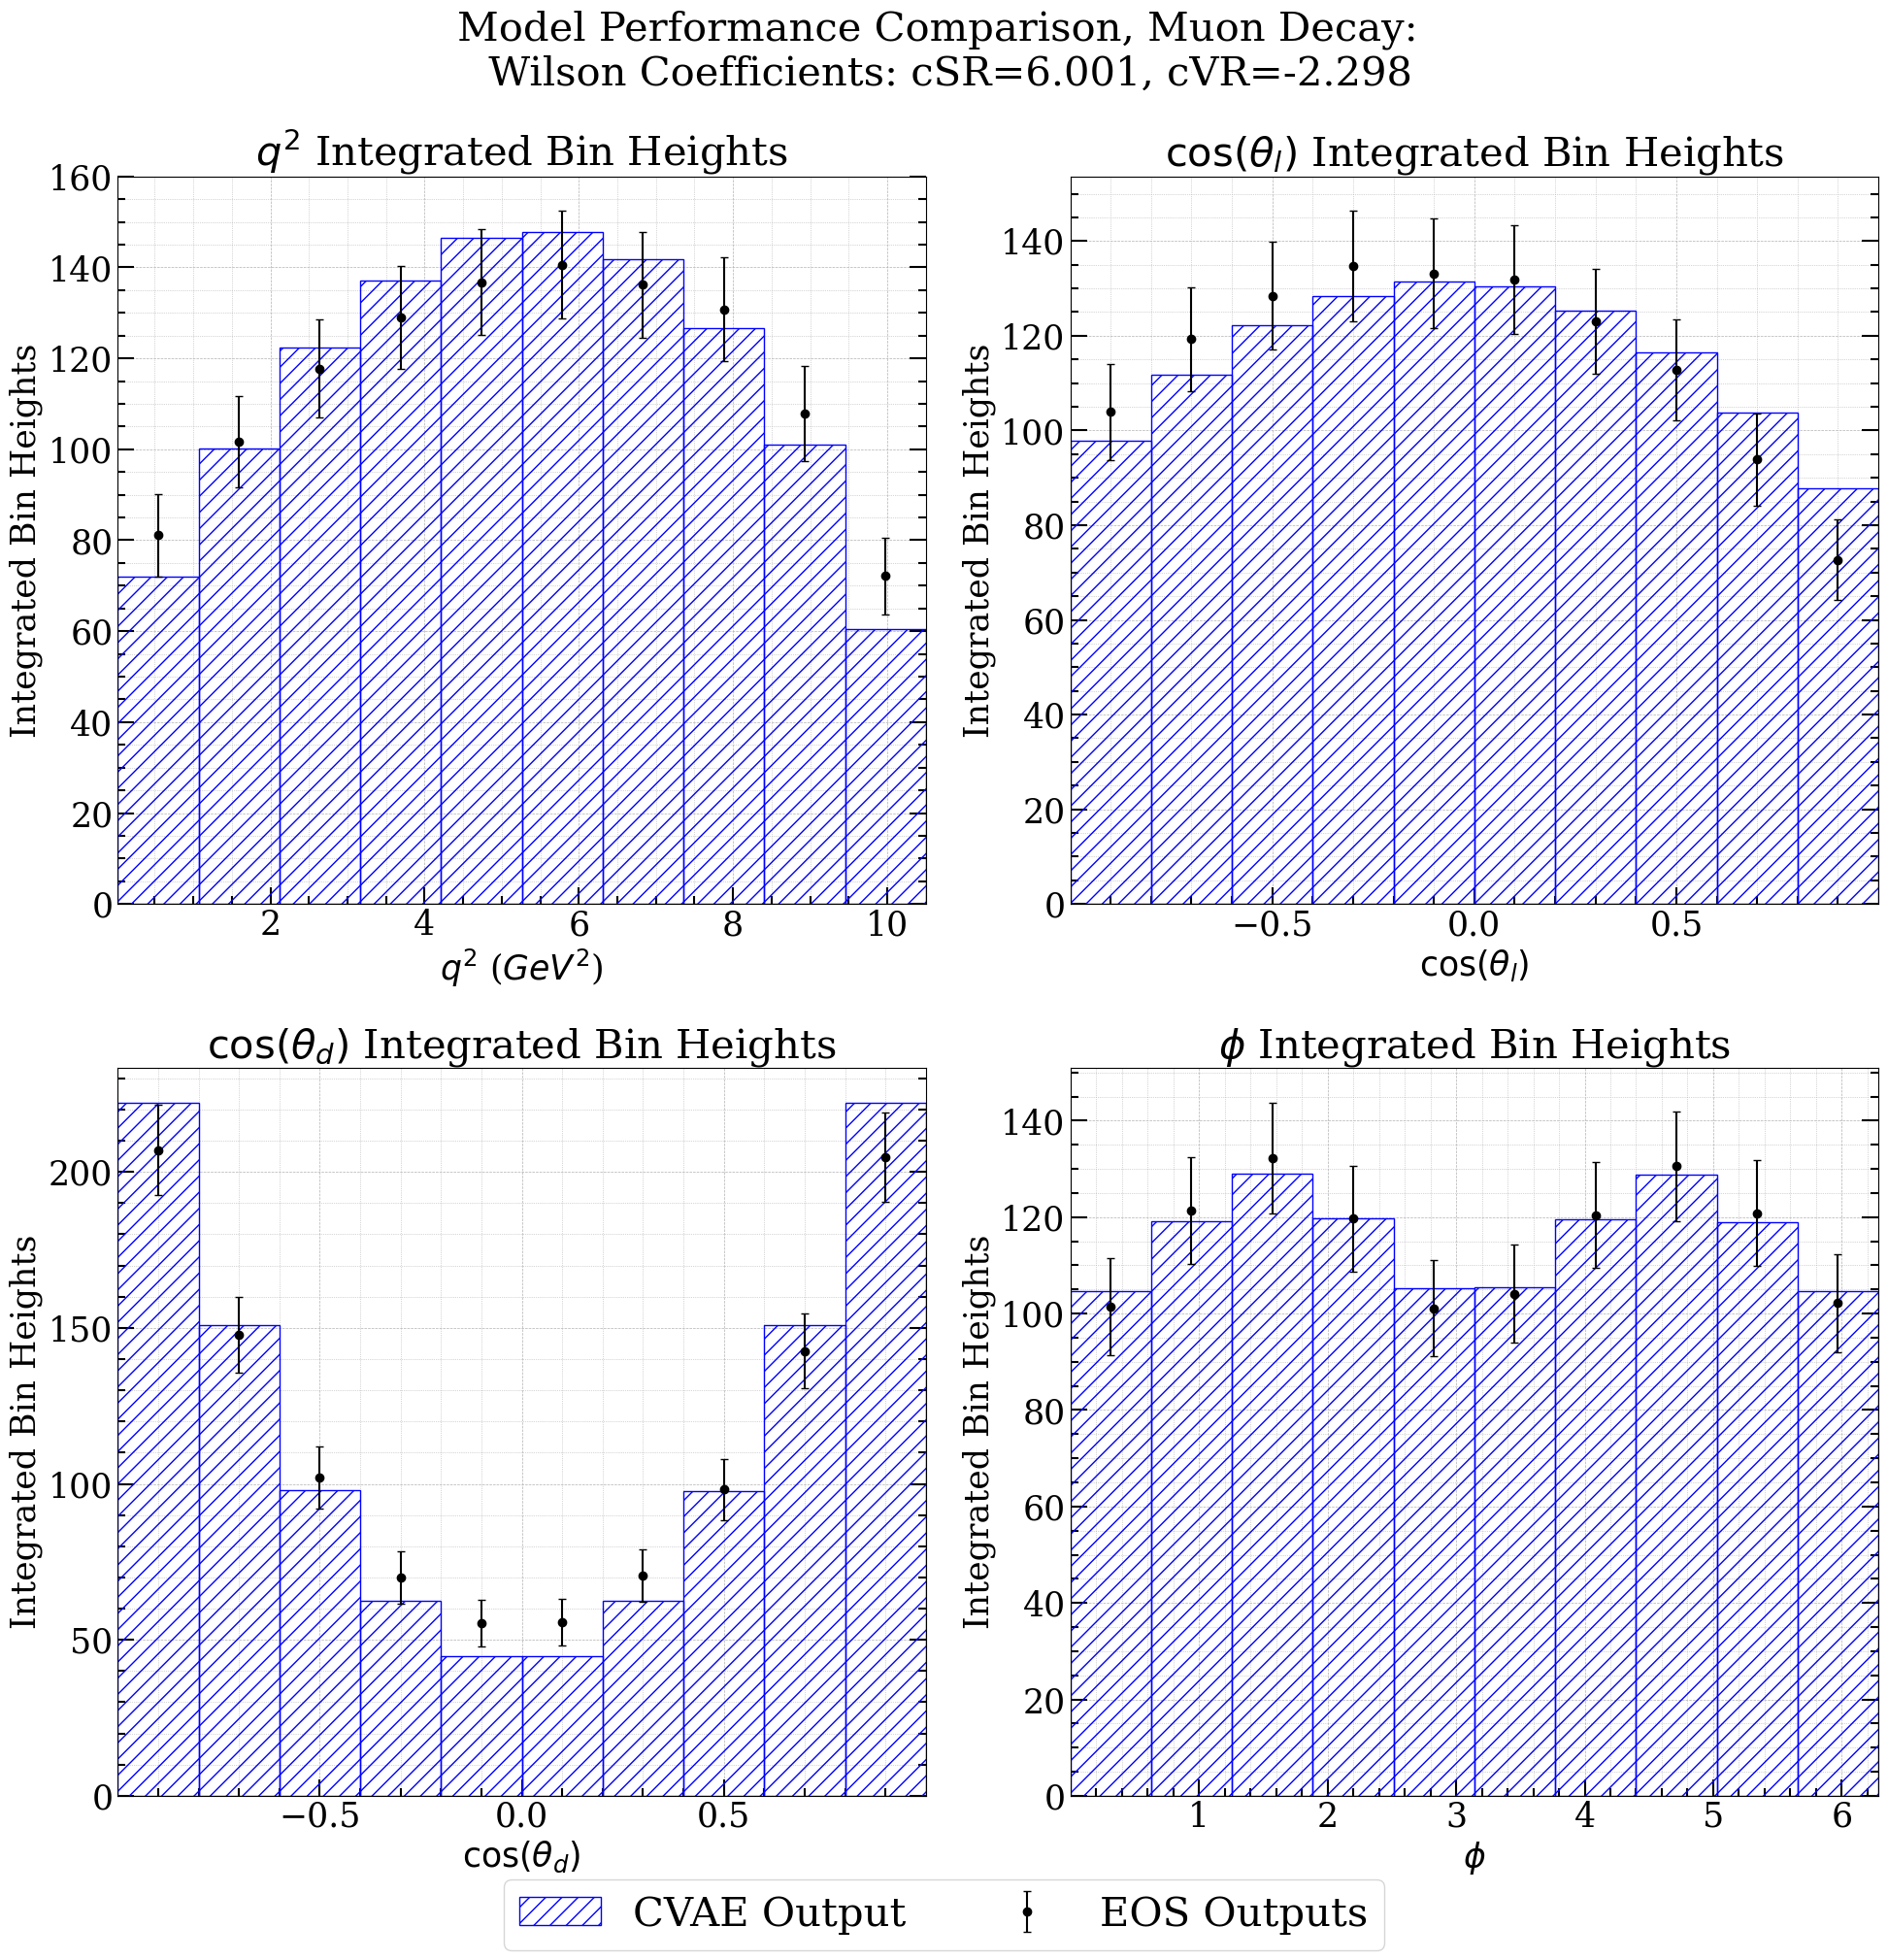

In [19]:
# File number must exist in the model_outputs directory
importlib.reload(me)
me.plot_1d_all_mu(data_path="nn_outputs/wilson_mu_csr_cvr", filenumber=2052, mode='linear')

## 7. Performance Evaluations

**Finds Memory used, run-time, number of parameters, etc.**

In [64]:
def count_parameters(state_dict):
    total_params = 0
    for param_tensor in state_dict:
        total_params += state_dict[param_tensor].numel()
    return total_params

# Load the state dictionary from the .pth file
state_dict = torch.load(normal_path + '/CVAE_tau_4d.pth', weights_only=False)

# Count the number of parameters
total_params = count_parameters(state_dict)

print(f'Total number of parameters: {total_params}')

Total number of parameters: 5712840


## 8. Rough Work - Random Tests of Specific Functionality

In [24]:
from scipy.stats import ks_2samp

files = glob.glob('nn_outputs/wilson_tau_csr_cvr_KLD_0.1/model_outputs/*.csv')
fnames = [os.path.basename(f) for f in files]

ps = []

for fname in tqdm(fnames):
    eos_path = os.path.join('nn_outputs/wilson_tau_csr_cvr_KLD_0.1/normal_targets', fname)
    nn_path = os.path.join('nn_outputs/wilson_tau_csr_cvr_KLD_0.1/linear_model_outputs', fname)

    # Load the datasets
    df_eos = pd.read_csv(eos_path)
    df_nn = pd.read_csv(nn_path)

    # Drop 'Unnamed: 0' column if it exists
    if 'Unnamed: 0' in df_eos.columns:
        df_eos = df_eos.drop(columns=['Unnamed: 0'])
    if 'Unnamed: 0' in df_nn.columns:
        df_nn = df_nn.drop(columns=['Unnamed: 0'])

    # Extract observable names dynamically (exclude "bin_height")
    observables = [col for col in df_eos.columns if col != "bin_height"]

    plt.rcParams["font.family"] = "Serif"
    plt.rcParams['font.size'] = 25

    # Loop through each observable and plot it
    for i, obs in enumerate(observables):
        # Integrate over the remaining columns for the current observable
        df_eos_integrated = df_eos.groupby([obs])["bin_height"].sum().reset_index()
        df_nn_integrated = df_nn.groupby([obs])["bin_height"].sum().reset_index()

        # Extract the heights for EOS and NN
        height_eos = df_eos_integrated["bin_height"].values
        height_nn = df_nn_integrated["bin_height"].values

        cdf_eos = np.cumsum(height_eos) / np.sum(height_eos)

        # Compute the CDF for NN
        cdf_nn = np.cumsum(height_nn) / np.sum(height_nn)

        ks_stat, p_value = ks_2samp(cdf_eos, cdf_nn)
        ps.append(p_value)

ps = np.array(ps)

mean_p = np.mean(ps)
std_p = np.std(ps)

print('Model Performance:', mean_p, '±', std_p)

100%|██████████| 534/534 [00:07<00:00, 68.69it/s]

Model Performance: 0.9998898689175065 ± 0.004615145772803605


In [73]:
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psutil

fixed_inputs = torch.Tensor([[0.0, 0.75]]).to(DEVICE)

csr_model_gen = nt.base_model(*cfg['dim'])

# =-=-= 1. Load best model data =-=-=
save_path = normal_path + '/linear_tau_4d.pth'
loss_func = cfg['loss_func']
csr_model_gen.load_state_dict(torch.load(save_path, weights_only = False))
csr_model_gen.to(DEVICE)

csr_model_gen.eval()

time_list = []
memory_usage_list = []

nbins=10

bin_edges = np.linspace(0, 1, nbins + 1)
bins = (bin_edges[:-1] + bin_edges[1:]) / 2

eos_ref = pd.read_csv('nn_outputs/wilson_tau_csr_cvr_KLD_0.1/normal_targets/model_WET_tau_0.csv', index_col = 0)

process = psutil.Process()

mean_mem = []

for j in range(25):
    memory_usage_list = []
    for i in range(50):
        with torch.no_grad():
            start_time = time.time()

            # Measure memory usage before model generation
            mem_before = process.memory_info().rss

            sample = csr_model_gen(fixed_inputs)

            outputs = sample.to('cpu')

            result_df = pd.DataFrame({
                    'q2':  eos_ref['q2'].values,
                    'cos_theta_l': eos_ref['cos_theta_l'].values,
                    'cos_theta_d': eos_ref['cos_theta_d'].values,
                    'phi': eos_ref['phi'].values,
                    'bin_height': outputs.ravel()
                })
            
            # df_integrated = result_df.groupby(['cos_theta_l'])["bin_height"].sum().reset_index()

            # Measure memory usage after model generation
            mem_after = process.memory_info().rss

            end_time = time.time()

            # Calculate memory usage for the model generation
            mem_usage = mem_after - mem_before
            memory_usage_list.append(mem_usage)

            delta = end_time - start_time

    mean_mem.append(np.mean(memory_usage_list))

# Print memory usage statistics

In [74]:
print(np.mean(mean_mem)/(1024**2), '±', np.std(mean_mem)/(1024**2))

0.0013 ± 0.003155699209367078
